0 Episode finished after 12.000000 time steps / mean 0.000000


/home/uu/.pyenv/versions/3.8.2/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
MovieWriter imagemagick unavailable; using Pillow instead.


1 Episode finished after 1.000000 time steps / mean -1.890000
2 Episode finished after 8.000000 time steps / mean -3.890000
3 Episode finished after 13.000000 time steps / mean -5.820000
4 Episode finished after 37.000000 time steps / mean -7.700000
5 Episode finished after 8.000000 time steps / mean -9.340000
6 Episode finished after 9.000000 time steps / mean -11.270000
7 Episode finished after 16.000000 time steps / mean -13.190000
8 Episode finished after 12.000000 time steps / mean -15.040000
9 Episode finished after 15.000000 time steps / mean -16.930000
10 Episode finished after 13.000000 time steps / mean -18.790000
11 Episode finished after 131.000000 time steps / mean -20.670000
12 Episode finished after 10.000000 time steps / mean -21.370000
13 Episode finished after 16.000000 time steps / mean -23.280000
14 Episode finished after 9.000000 time steps / mean -25.130000
15 Episode finished after 17.000000 time steps / mean -27.050000
16 Episode finished after 13.000000 time st

MovieWriter imagemagick unavailable; using Pillow instead.


179 Episode finished after 1.000000 time steps / mean 197.910000


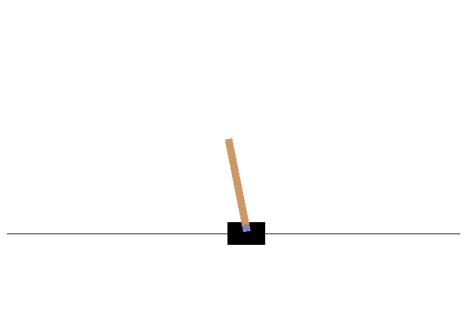

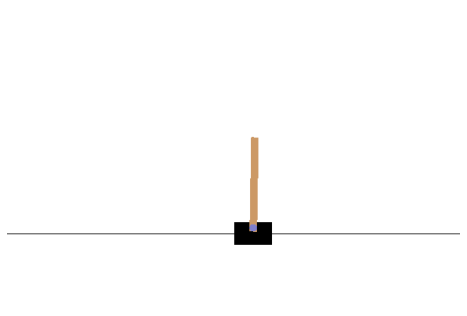

In [23]:
# coding:utf-8
# [0]ライブラリのインポート
import gym  #倒立振子(cartpole)の実行環境
from gym import wrappers  #gymの画像保存
import numpy as np
import time
import os

os.makedirs("gif", exist_ok=True)


# [1]Q関数を離散化して定義する関数　------------
# 観測した状態を離散値にデジタル変換する
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]
 
# 各値を離散値に変換
def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, num_dizitized)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, num_dizitized)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, num_dizitized)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, num_dizitized))
    ]
    return sum([x * (num_dizitized**i) for i, x in enumerate(digitized)])


# [2]行動a(t)を求める関数 -------------------------------------
def get_action(next_state, episode):
           #徐々に最適行動のみをとる、ε-greedy法
    epsilon = 0.5 * (1 / (episode + 1))
    if epsilon <= np.random.uniform(0, 1):
        next_action = np.argmax(q_table[next_state])
    else:
        next_action = np.random.choice([0, 1])
    return next_action


# [3]Qテーブルを更新する関数 -------------------------------------
def update_Qtable(q_table, state, action, reward, next_state):
    gamma = 0.99
    alpha = 0.5
    next_Max_Q=max(q_table[next_state][0],q_table[next_state][1] )
    q_table[state, action] = (1 - alpha) * q_table[state, action] +\
            alpha * (reward + gamma * next_Max_Q)
   
    return q_table
 
# [4]. メイン関数開始 パラメータ設定--------------------------------------------------------
env = gym.make('CartPole-v0')
max_number_of_steps = 200  #1試行のstep数
num_consecutive_iterations = 100  #学習完了評価に使用する平均試行回数
num_episodes = 2000  #総試行回数
goal_average_reward = 195  #この報酬を超えると学習終了（中心への制御なし）
# 状態を6分割^（4変数）にデジタル変換してQ関数（表）を作成
num_dizitized = 6  #分割数
q_table = np.random.uniform(
    low=-1, high=1, size=(num_dizitized**4, env.action_space.n))
 
total_reward_vec = np.zeros(num_consecutive_iterations)  #各試行の報酬を格納
final_x = np.zeros((num_episodes, 1))  #学習後、各試行のt=200でのｘの位置を格納
islearned = 0  #学習が終わったフラグ
isrender = 0  #描画フラグ
issaved = 0


# [5] メインルーチン--------------------------------------------------
for episode in range(num_episodes):  #試行数分繰り返す
    # 環境の初期化
    observation = env.reset()
    state = digitize_state(observation)
    action = np.argmax(q_table[state])
    episode_reward = 0
    
    frames = []
    for t in range(max_number_of_steps):  #1試行のループ
#         print(frame)
        if islearned == 1:
            if issaved == 1:
                break
            for _ in range(6000):
                frame = env.render(mode='rgb_array')
                frames.append(frame)
                observation, reward, done, info = env.step(action)
                if done:
                    break
                next_state = digitize_state(observation)
                action = get_action(next_state, episode)
#             issaved = 1
#         if islearned == 1:  #学習s終了したらcartPoleを描画する
            
#             time.sleep(0.1)
#             print (observation[0])  #カートのx位置を出力
 
        # 行動a_tの実行により、s_{t+1}, r_{t}などを計算する
        observation, reward, done, info = env.step(action)
 
        # 報酬を設定し与える
        if done:
            if t < 195:
                reward = -200  #こけたら罰則
            else:
                reward = 1  #立ったまま終了時は罰則はなし
        else:
            reward = 1  #各ステップで立ってたら報酬追加
 
        episode_reward += reward  #報酬を追加
 
        # 離散状態s_{t+1}を求め、Q関数を更新する
        next_state = digitize_state(observation)  #t+1での観測状態を、離散値に変換
        q_table = update_Qtable(q_table, state, action, reward, next_state)
        
        #  次の行動a_{t+1}を求める 
        action = get_action(next_state, episode)    # a_{t+1} 
        
        state = next_state
        
        #終了時の処理
        if done:
            print('%d Episode finished after %f time steps / mean %f' %
                  (episode, t + 1, total_reward_vec.mean()))
            total_reward_vec = np.hstack((total_reward_vec[1:],
                                          episode_reward))  #報酬を記録
            if islearned == 1:  #学習終わってたら最終のx座標を格納
                final_x[episode, 0] = observation[0]
            break

    if islearned == 1:
        if issaved ==1:
            break
        save_frames_as_gif(frames, path="gif/", filename=f"{str(episode).zfill(3)}_.gif")
        issaved = 1
    if (total_reward_vec.mean() >=
            goal_average_reward):  # 直近の100エピソードが規定報酬以上であれば成功
        print('Episode %d train agent successfuly!' % episode)
        islearned = 1
        #np.savetxt('learned_Q_table.csv',q_table, delimiter=",") #Qtableの保存する場合
        if isrender == 0:
            #env = wrappers.Monitor(env, './movie/cartpole-experiment-1') #動画保存する場合
            isrender = 1
    #10エピソードだけでどんな挙動になるのか見たかったら、以下のコメントを外す
    #if episode>10:
    #    if isrender == 0:
    #        env = wrappers.Monitor(env, './movie/cartpole-experiment-1') #動画保存する場合
    #        isrender = 1
    #    islearned=1;

# if islearned:
#     np.savetxt('final_x.csv', final_x, delimiter=",")


In [ ]:
from matplotlib import animation
import matplotlib.pyplot as plt
import gym 

"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [ ]:
frames = []
for _ in range(1000):
    